# Model Stealing Attack



### This notebook demonstrates an advanced model stealing attack with:


### 0. Libraries Import

In [1]:
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

2025-02-16 00:35:28.921413: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 00:35:29.157833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739666129.397599  127772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739666129.434348  127772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 00:35:29.600295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### 1. API interaction

In [2]:
# Configuration
API_URL = "http://localhost:5000/predict"

### 2. Multiple surrogate architectures


In [3]:
class ModelStealingAttack:
    def __init__(self, input_shape=(28, 28, 1), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.target_predictions = []
        
    def query_target_model(self, image):
        """Query the target model API"""
        try:
            response = requests.post(
                API_URL,
                json={'image': image.reshape(28, 28).tolist()}
            )
            return np.array(response.json()['full_probabilities'])
        except Exception as e:
            print(f"Error querying model: {e}")
            return None
    
    def create_surrogate_model(self):
        """Create a simpler surrogate model"""
        model = tf.keras.Sequential([
            # First Convolutional Block
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                                 input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            
            # Second Convolutional Block
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.25),
            
            # Dense Layers
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

In [4]:
def evaluate_stealing(surrogate_preds, target_preds, true_labels):
    """Evaluate model stealing success"""
    surrogate_classes = np.argmax(surrogate_preds, axis=1)
    target_classes = np.argmax(target_preds, axis=1)
    
    results = {
        'accuracy': np.mean(surrogate_classes == true_labels),
        'agreement': np.mean(surrogate_classes == target_classes),
        'confidence_correlation': np.corrcoef(
            np.max(surrogate_preds, axis=1),
            np.max(target_preds, axis=1)
        )[0, 1]
    }
    return results

def plot_comparison(sample_image, target_pred, surrogate_pred, true_label):
    """Visualize predictions comparison"""
    plt.figure(figsize=(15, 4))
    
    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f'True Label: {true_label}')
    plt.axis('off')
    
    # Target Model Prediction
    plt.subplot(1, 3, 2)
    plt.bar(range(10), target_pred)
    plt.title(f'Target Model\nPrediction: {np.argmax(target_pred)}')
    plt.ylim(0, 1)
    
    # Surrogate Model Prediction
    plt.subplot(1, 3, 3)
    plt.bar(range(10), surrogate_pred)
    plt.title(f'Surrogate Model\nPrediction: {np.argmax(surrogate_pred)}')
    plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

In [5]:
# Load MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Data shapes:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

Loading MNIST dataset...
Data shapes:
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


In [9]:
# Initialize attack
attack = ModelStealingAttack()

# Query target model
print("Querying target model...")
num_samples = 2000  # Number of samples to use
target_predictions = []

# Simple progress tracking
for i in range(num_samples):
    if i % 100 == 0:  # Show progress every 100 samples
        print(f"Progress: {i}/{num_samples} samples", end='\r')
    
    pred = attack.query_target_model(x_train[i])
    if pred is not None:
        target_predictions.append(pred)
        
        # Add some basic validation
        if len(target_predictions) % 500 == 0:
            print(f"\nValidation at {len(target_predictions)} samples:")
            print(f"Unique predictions so far: {np.unique(np.argmax(target_predictions, axis=1))}")

target_predictions = np.array(target_predictions)
print(f"\nFinished! Collected {len(target_predictions)} predictions")

# Quick validation of collected predictions
print("\nPrediction Analysis:")
print(f"Shape of predictions: {target_predictions.shape}")
print(f"Unique predicted classes: {np.unique(np.argmax(target_predictions, axis=1))}")
print(f"Average confidence: {np.mean(np.max(target_predictions, axis=1)):.4f}")

Querying target model...
Progress: 400/2000 samples
Validation at 500 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 900/2000 samples
Validation at 1000 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 1400/2000 samples
Validation at 1500 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]
Progress: 1900/2000 samples
Validation at 2000 samples:
Unique predictions so far: [0 1 2 3 4 5 6 7 8 9]

Finished! Collected 2000 predictions

Prediction Analysis:
Shape of predictions: (2000, 10)
Unique predicted classes: [0 1 2 3 4 5 6 7 8 9]
Average confidence: 0.9979


In [15]:
# Create and train surrogate model
print("Training surrogate model...")
surrogate_model = attack.create_surrogate_model()

# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )
]

# Train model
history = surrogate_model.fit(
    x_train[:num_samples],
    target_predictions,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Training surrogate model...
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3219 - loss: 2.5143 - val_accuracy: 0.4475 - val_loss: 1.9310 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7124 - loss: 0.8886 - val_accuracy: 0.3850 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7827 - loss: 0.6826 - val_accuracy: 0.3200 - val_loss: 1.7680 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8513 - loss: 0.4858 - val_accuracy: 0.3800 - val_loss: 1.6262 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8773 - loss: 0.4282 - val_accuracy: 0.4575 - val_loss: 1.3539 - learning_rate: 0.0010
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8930 - loss: 0.3549 - val_accuracy: 0.5650 - val_loss: 1.1324 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9

In [16]:
# Evaluate attack
print("Evaluating attack...")
test_samples = 100
test_target_preds = []

# Simple progress tracking for evaluation
for i in range(test_samples):
    if i % 10 == 0:  # Update progress every 10 samples
        print(f"Progress: {i}/{test_samples} samples", end='\r')
    
    pred = attack.query_target_model(x_test[i])
    if pred is not None:
        test_target_preds.append(pred)

test_target_preds = np.array(test_target_preds)
print(f"\nCollected {len(test_target_preds)} test predictions")

# Get surrogate model predictions
surrogate_preds = surrogate_model.predict(x_test[:test_samples], verbose=0)

# Calculate results
results = evaluate_stealing(
    surrogate_preds,
    test_target_preds,
    y_test[:test_samples]
)

print("\nAttack Results:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Prediction Agreement: {results['agreement']:.4f}")
print(f"Confidence Correlation: {results['confidence_correlation']:.4f}")

# Additional analysis
print("\nPrediction Analysis:")
print("Target Model:")
print(f"- Unique predictions: {np.unique(np.argmax(test_target_preds, axis=1))}")
print(f"- Mean confidence: {np.mean(np.max(test_target_preds, axis=1)):.4f}")
print("\nSurrogate Model:")
print(f"- Unique predictions: {np.unique(np.argmax(surrogate_preds, axis=1))}")
print(f"- Mean confidence: {np.mean(np.max(surrogate_preds, axis=1)):.4f}")

Evaluating attack...
Progress: 90/100 samples
Collected 100 test predictions

Attack Results:
Accuracy: 0.9900
Prediction Agreement: 0.9900
Confidence Correlation: 0.2899

Prediction Analysis:
Target Model:
- Unique predictions: [0 1 2 3 4 5 6 7 8 9]
- Mean confidence: 0.9985

Surrogate Model:
- Unique predictions: [0 1 2 3 4 5 6 7 8 9]
- Mean confidence: 0.9622


Visualizing examples...


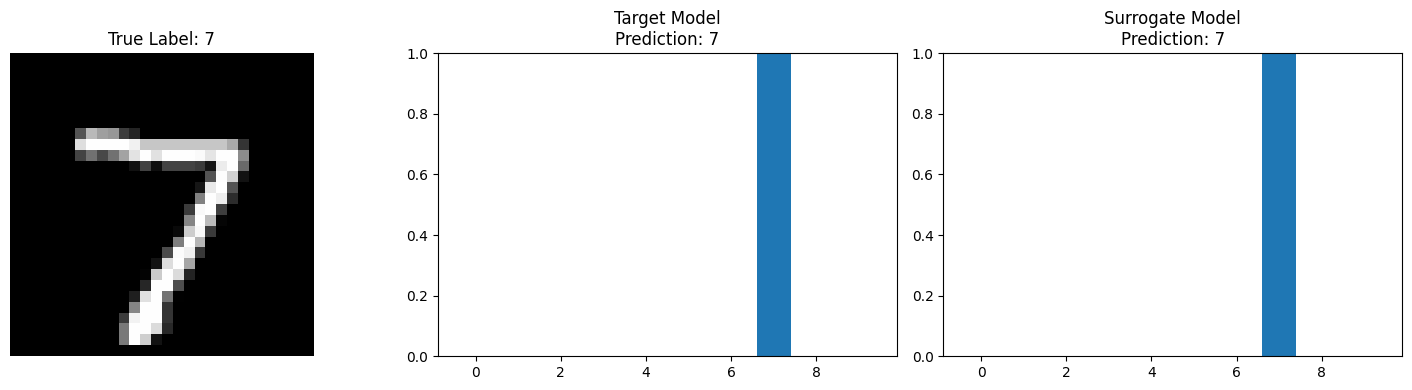

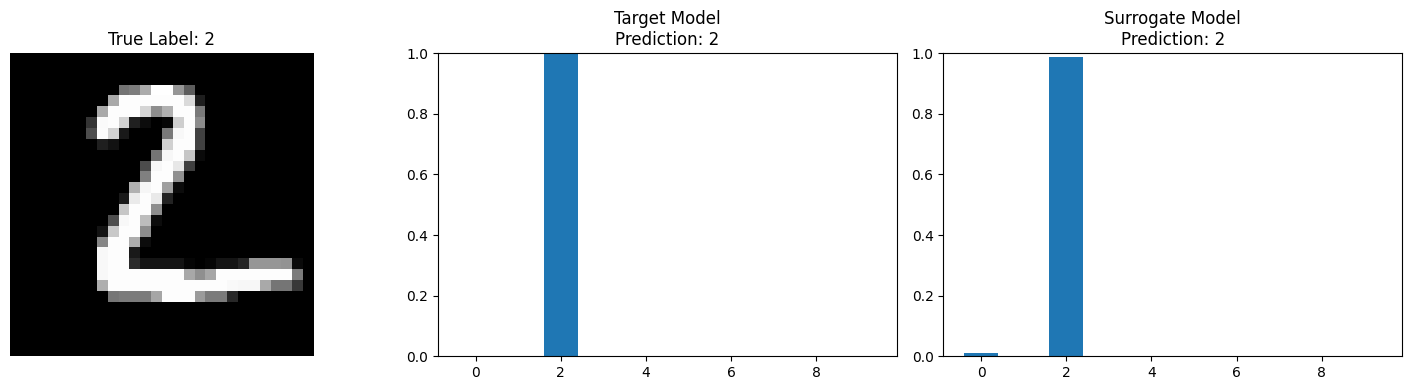

Exception ignored in: <function tqdm.__del__ at 0x710ad166d8a0>
Traceback (most recent call last):
  File "/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


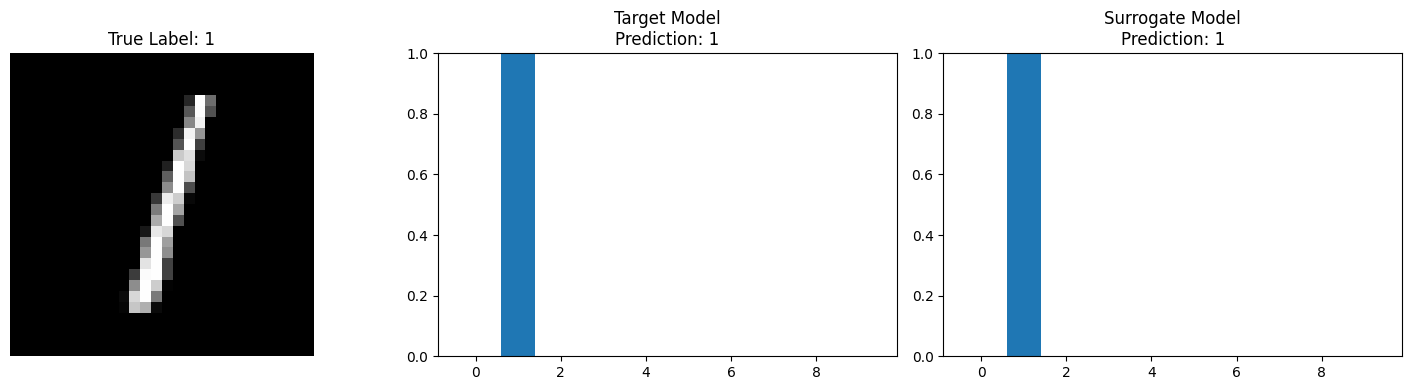


Surrogate model saved as 'stolen_model.keras'


In [17]:
# Visualize examples
print("Visualizing examples...")
for i in range(3):
    plot_comparison(
        x_test[i],
        test_target_preds[i],
        surrogate_preds[i],
        y_test[i]
    )

# Save surrogate model
surrogate_model.save('stolen_model.keras')
print("\nSurrogate model saved as 'stolen_model.keras'")